In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
from matplotlib import cm
cmap="viridis"
viridis = cm.get_cmap(cmap, 256)
newcolors = viridis(np.linspace(0, 1, 256))
black = np.array([80/255, 80/255, 80/255, 1])
newcolors[:1, :] = black
cmap = ListedColormap(newcolors)

cm = 1/2.54  # centimeters in inches
Start=0
Duration=5000
Q=20
Ne=20000
NNeuronsE=40
NNeuronsI=NNeuronsE//4

vmin=0
vmax=5

ModuloRow=2
ModuloColumn=2

fontsizeTicks=8
fontsizeLabels=10
fontsizeSubfigure=14

OffsetLetBottom=np.array([0,1])
B="NEST_S3"
C="GeNN_S3_B40"


In [3]:
DataPathPrefix=os.path.split(os.getcwd())[0]+"/Data"
Pathfolder=DataPathPrefix +"/Gridsearch/"

Names=["NEST_S3", "GeNN_S3_B40", "GeNN_S3_B1", "NEST_S2", "GeNN_S1_B1"]

DataSet=[(Pathfolder+ x + ".pkl", Pathfolder+ x + "_Times.pkl") for x in Names]
Spikepath=Pathfolder+"Spikes.pkl"
file_exists = os.path.exists(Spikepath)
print(file_exists)
if not file_exists:
    Spikepath=None

True


In [4]:
Params=[]
SetArray=False
for ii, (dat,_) in enumerate(DataSet):
    with open(dat, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        try:
            while True:
                data = pickle.load(f)
                if isinstance(data,np.ndarray):
                    if SetArray==False:
                        SetArray=True
                        dataE= np.zeros(tuple(list(data.shape) + [len(DataSet)]))
                        dataI= np.zeros(tuple(list(data.shape) + [len(DataSet)]))
                        Params.append(data)


                if len(data)==2:
                    if type(data[0][0])==float and type(data[0][1])==float:
                        #print(np.hstack((data[1],ii)))
                        #print(data[0][0])
                        dataE[tuple(np.hstack((data[1],ii)))]=data[0][0]
                        dataI[tuple(np.hstack((data[1],ii)))]=data[0][1]

        except EOFError as e:
            print("Dataset" + str(ii+1) + " loaded.")

Dataset1 loaded.
Dataset2 loaded.
Dataset3 loaded.
Dataset4 loaded.
Dataset5 loaded.


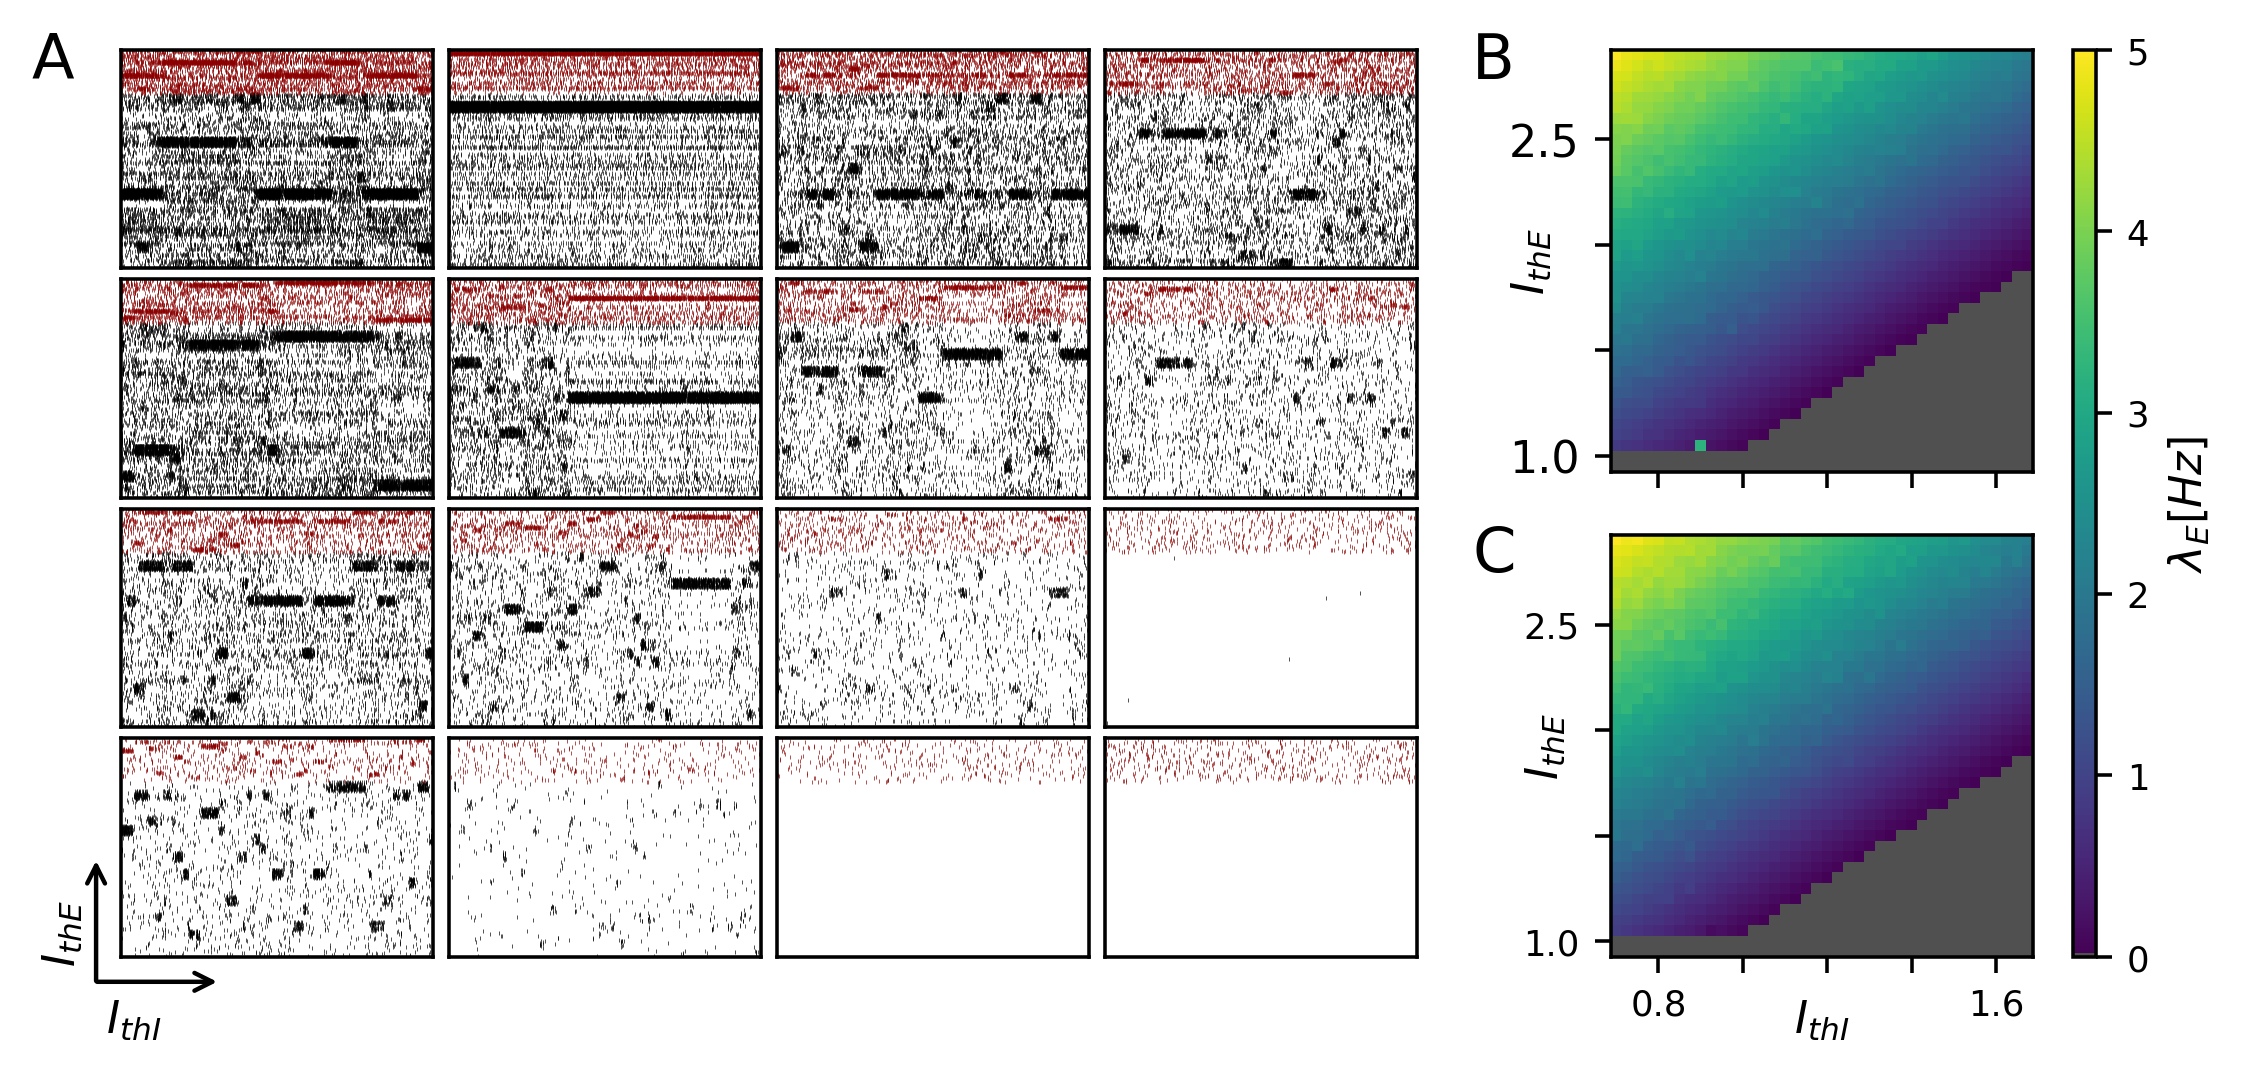

In [5]:
IDXin=[int(ii+jj*(Ne//Q)) for jj in range(Q) for ii in range(NNeuronsE)]
IDXin+=[int(Ne+ii+jj*((Ne//4)//Q)) for jj in range(Q) for ii in range(NNeuronsI)]
IDXin=np.array(IDXin)
IDXin=np.array(IDXin)

fig = plt.figure(figsize=(18*cm, 9*cm), dpi=320)
plt.figtext(0.05, 0.875, "A", fontsize=fontsizeSubfigure)
plt.figtext(0.685, 0.875, "B", fontsize=fontsizeSubfigure)
plt.figtext(0.685, 0.44, "C", fontsize=fontsizeSubfigure)

subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[2.5, 1.])

dictGrid={'left':0.125,
                    'bottom':0.1,
                    'right':0.925,
                    'top':0.9,
                    'wspace':0.05,
                    'hspace':0.05}

ax = subfigs[0].subplots(8//ModuloRow, 8//ModuloColumn, gridspec_kw=dictGrid)



ax2 = subfigs[1].subplots(2, 1, sharex=True)

plt.subplots_adjust(left=0.025,
                    bottom=0.1,
                    right=1,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.15)


OffsetLetBottom=np.mod(OffsetLetBottom, np.array([ModuloRow, ModuloColumn]))
if Spikepath is None:
    print("Please provide spiking data. The data has to be obtained manually due to the datasize limit of GitHub.")
    for ax_l in ax.ravel():
        ax_l.axes.xaxis.set_visible(False)
        ax_l.axes.yaxis.set_visible(False)
else:
    with open(Spikepath, 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        try:
            jj=0
            while True:
                jj=jj+1
                data = pickle.load(f)
                Pos=np.abs(data[1]-np.array([7,0]))
                if ((np.mod(Pos, np.array([ModuloRow, ModuloColumn]))==OffsetLetBottom).all()):
                    Pos=tuple([Pos[0]//ModuloRow, Pos[1]//ModuloColumn])
                    SpikesT=np.array(data[0][0,:])
                    SpikeIdx=np.array(data[0][1,:]).astype(int)

                    try:
                        SpikeInIDX= np.isin(SpikeIdx,IDXin)
                        SpikesT=SpikesT[SpikeInIDX]
                        SpikeIdx=SpikeIdx[SpikeInIDX]

                        xsorted = np.argsort(IDXin)
                        ypos = np.searchsorted(IDXin[xsorted], SpikeIdx)
                        indices = xsorted[ypos]
                        SpikeIdx=IDXin[indices]

                        ax[Pos].plot(SpikesT[indices<(Q*NNeuronsE)],indices[indices<(Q*NNeuronsE)], 'k|', markersize=0.75, markeredgewidth=0.15)
                        ax[Pos].plot(SpikesT[indices>=(Q*NNeuronsE)],indices[indices>=(Q*NNeuronsE)], '|', color='darkred', markersize=0.75, markeredgewidth=0.15)
                        ax[Pos].set_xlim(Start,Start+Duration)
                        ax[Pos].set_ylim(0,Q*(NNeuronsE+NNeuronsI))
                    except:
                        pass
                    ax[Pos].axes.xaxis.set_visible(False)
                    ax[Pos].axes.yaxis.set_visible(False)
        except:
           pass



yvalues=[val[0] for val in np.array(Params[0])[:,0] ]
xvalues=[val[1]/2 for val in np.array(Params[0])[0,:] ]

ax2[0].pcolormesh(dataE[:,:,Names.index(B)], vmin=vmin, vmax=vmax, cmap=cmap)
ax2[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ticks=np.arange(1.5,38.5, 10)
ax2[0].yaxis.set(ticks=ticks)
Values=[round(yvalues[id],3) for id in range(1,37,10)]
Labels=["" for ii in ticks]
Labels[0]=Values[0]
Labels[-1]=Values[-1]

ax2[0].yaxis.set( ticklabels=Labels)
ax2[0].tick_params(axis='x', labelsize=fontsizeTicks)
ax2[0].set_aspect(1)


yvalues=[val[0] for val in np.array(Params[0])[:,0] ]
xvalues=[val[1]/2 for val in np.array(Params[0])[0,:] ]

colorbarParent=ax2[1].pcolormesh(dataE[:,:,Names.index(C)], vmin=vmin, vmax=vmax, cmap=cmap)

ax2[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ticks=np.arange(4.5,38.5, 8)
ax2[1].xaxis.set(ticks=ticks)
Values=[round(xvalues[id],3) for id in range(4,37,8)]
Labels=["" for ii in ticks]
Labels[0]=Values[0]
Labels[-1]=Values[-1]

ax2[0].xaxis.set( ticklabels=Labels)
ax2[0].tick_params(axis='x', labelsize=fontsizeTicks)


ticks=np.arange(1.5,38.5, 10)
ax2[1].yaxis.set(ticks=ticks)
Values=[round(yvalues[id],3) for id in range(1,37,10)]
Labels=["" for ii in ticks]
Labels[0]=Values[0]
Labels[-1]=Values[-1]

ax2[1].yaxis.set( ticklabels=Labels)
ax2[1].tick_params(axis='x', labelsize=fontsizeTicks)
ax2[1].tick_params(axis='y', labelsize=fontsizeTicks)
ax2[1].set_aspect(1)


ax2[1].set_xlabel(r'$I_{thI}$', fontsize=fontsizeLabels, labelpad=-5.5)
ax2[0].set_ylabel(r'$I_{thE}$', fontsize=fontsizeLabels, labelpad=-10)
ax2[1].set_ylabel(r'$I_{thE}$', fontsize=fontsizeLabels, labelpad=-10)


subfigs[1].subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.8])

cbar=plt.colorbar(colorbarParent,cax=cbar_ax)
cbar.set_label(r'$\lambda_E [Hz]$',size=fontsizeLabels,weight='bold')
cbar.ax.tick_params(labelsize=fontsizeTicks)


ax[3,0].annotate('', xy=(-33, -25), xycoords='axes pixels', xytext=(105, -25),
            arrowprops=dict(arrowstyle="<-", color='k'))

ax[3,0].annotate('', xy=(-25, -33), xycoords='axes pixels', xytext=(-25, 105),
            arrowprops=dict(arrowstyle="<-", color='k'))

ax[3,0].annotate(r'$I_{thI}$', xy=(-15, -76), xycoords='axes pixels', fontsize=fontsizeLabels)
ax[3,0].annotate(r'$I_{thE}$', xy=(-80, 0), rotation=90.0, xycoords='axes pixels', fontsize=fontsizeLabels)

plt.savefig('Figure_Gridsearch.png', bbox_inches="tight")

In [6]:
#Timing: (more information on single runs can be accessed by iterating through pickle file)
#B
print(B)
with open(DataSet[Names.index(B)][1], 'rb') as f:
    DictGridB=pickle.load(f)
    print("Time whole grid [s]: ", DictGridB['TotalTime'])
    
print(C)
with open(DataSet[Names.index(C)][1], 'rb') as f:
    DictGridC=pickle.load(f)
    print("Time whole grid [s]: ", DictGridC['TotalTime'])
    
print("Speedup=", DictGridB['TotalTime']/DictGridC['TotalTime'])

NEST_S3
Time whole grid [s]:  45917.902626514435
GeNN_S3_B40
Time whole grid [s]:  2309.2077746391296
Speedup= 19.884699476074747
